# Particle Size Distribution Analysis for Annealed Samples

**Created on:** 23/10/2024  
**Author:** Dmitry Chezganov  

## Description

This notebook performs a comprehensive analysis of particle size distribution (PSD) for the sample of ferroelectic MgO-doped Lithium Niobate (MgOLN) exposed to e-beam scanning with different charge doses and e-beam current. The purpose of e-beam exposure is creation of ferroelectric polydomain state. The variation of dose and current results in the changes of domain density and domain size. The Notebook includes the analysis of data extracted by ML image segmenation (see corresponding notebook) for the sample of MgOLN annedled before expusre.
The analysis includes the following steps:

1. **Import Data**:
   - Import all 100 CSV files containing particle size measurements.

2. **Data Preparation**:
   - Combine all data into a single DataFrame.
   - Extract dose and current values from the file names.
   - Clean the data by removing duplicates and outliers.

3. **Descriptive Statistics**:
   - Calculate and display descriptive statistics for each particle size metric.

4. **Visualization**:
   - Plot particle size distribution for each combination of dose and current.
   - Generate histograms and KDE plots for all doses at fixed currents and all currents at fixed doses.
   - Create box plots and bar plots for all doses at fixed currents and all currents at fixed doses.
   - Plot histograms, box plots, and bar plots for doses assuming no dependence on current, and for currents assuming no dependence on dose.

5. **Density Calculation**:
   - Calculate particle density for each combination of dose and current.
   - Save the density results to a CSV file.

6. **Correlation Analysis**:
   - Generate a correlation matrix for all particle size metrics.

7. **Regression Analysis**:
   - Conduct regression analysis to explore relationships between variables.

## Steps in Detail

1. **Import Libraries**:
   - Import necessary libraries such as `cv2`, `matplotlib`, `pandas`, `seaborn`, etc.

2. **Helper Functions**:
   - Define functions for creating folders, extracting dose and current from file names, cleaning data, and removing outliers.

3. **Paths to Data Files and Output Folder**:
   - Set paths to the folder containing CSV files and the folder to save results.

4. **Load and Combine Data**:
   - Load data from all CSV files and combine them into a single DataFrame.
   - Extract dose and current values from file names and add them as columns in the DataFrame.

5. **Remove Duplicates**:
   - Remove duplicate entries that may have appeared due to the same particle being detected in the same image.

6. **Extract Image Size**:
   - Extract the size of the image from the first image, assuming all images have the same size.

7. **Calculate Particle Density**:
   - Calculate the density of particles for each combination of dose and current and save the results to a CSV file.

8. **Plotting**:
   - Generate various plots to visualize the particle size distribution, including histograms, KDE plots, box plots, and bar plots.

9. **Save Filtered Data**:
   - Save the cleaned and filtered DataFrame to a CSV file.

10. **Regression Analysis**:
    - Conduct regression analysis to explore relationships between variables.

## Note

Ensure that the paths to the data files and the output folder are correctly set before running the notebook. The notebook assumes that all images have the same size for certain calculations.

In [2]:
import cv2
import matplotlib.pyplot as plt
import time
import os
import numpy as np
import glob
import hyperspy.api as hs
import pandas as pd
import re
import seaborn as sns

Heplful functions

In [3]:
#* create a folder to save the results
def make_folder(save_path, folder_name):
    """
    Create a folder to save the output
    This function creates a folder for the output of the experiment.
    It takes two arguments: the path to the folder where the output should be saved, and the name of the folder.
    If the folder already exists, it will not be overwritten, but a message will be printed.
    The function returns the path to the output folder.

    Args:
        save_path (str): folder where to create the folder to save results
        folder_name (str): folder to save results

    Returns:
        str: path to folder to save results
    """
    # Check if the folder already exists
    if not os.path.exists(os.path.join((save_path + folder_name))):
        try:
            # If it doesn't exist, create the folder
            os.makedirs(os.path.join(save_path + folder_name))
        except OSError: 
            # If the creation of the folder failed, print a message
            print(f'Creation of the directory {os.path.join(save_path + folder_name)} failed. Probably already present.')
    else:
        # If the folder already exists, print a message
        print(f'Directory {os.path.join(save_path + folder_name)} already exists.')
    # Return the path to the folder
    path_to_save = save_path +folder_name+'/'
    return path_to_save

#* Function to extract dose and current from the file name
def extract_dose_and_current(file_name):
    """
    Extracts the dose and current from a given file name.

    The function uses a regular expression to search for patterns in the file name
    that match the format 'DF<dose>_<current>pA'. If a match is found, it extracts
    the dose and current values and returns them as integers. If no match is found,
    it returns (None, None).

    Args:
        file_name (str): The name of the file from which to extract the dose and current.

    Returns:
        tuple: A tuple containing two elements:
            - dose (int or None): The extracted dose value, or None if no match is found.
            - current (int or None): The extracted current value, or None if no match is found.
    """
    # Use regular expression to find dose and current in the file name
    match = re.search(r'DF(\d+)_+(\d+)pA', file_name)
    if match:
        dose = int(match.group(1))
        current = int(match.group(2))
        return dose, current
    else:
        return None, None

#* data cleaning functions
def clean_data(df):
    """
    Cleans the given DataFrame by performing the following operations:
    
    1. Removes rows containing NaN values.
    2. Removes rows where any column contains a zero value.
    
    Parameters:
    df (pandas.DataFrame): The DataFrame to be cleaned.
    
    Returns:
    pandas.DataFrame: The cleaned DataFrame with no NaN values and no rows with zero values.
    """
    # remove rows with NaN
    df = df.dropna()
    # remove rows with zeros
    df = df[(df.T != 0).all()]
    return df
def remove_outliers(df, column, lower_quantile, upper_quantile):
    """
    Remove outliers from a DataFrame based on the Interquartile Range (IQR) method.

    Parameters:
    df (pandas.DataFrame): The input DataFrame.
    column (str): The column name from which to remove outliers.
    lower_quantile (float): The lower quantile threshold (e.g., 0.25 for 25th percentile).
    upper_quantile (float): The upper quantile threshold (e.g., 0.75 for 75th percentile).

    Returns:
    pandas.DataFrame: A DataFrame with outliers removed based on the specified column and quantiles.
    """
    Q1 = df[column].quantile(lower_quantile)
    Q3 = df[column].quantile(upper_quantile)
    IQR = Q3 - Q1
    df_out = df[~((df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR)))]
    return df_out

def remove_outliers2(df, column='Area_nm'):
    """
    Remove outliers based on the Interquartile Range (IQR) method for the specified column.
    Parameters:
    df (pandas.DataFrame): The DataFrame containing the data.
    column (str): The name of the column for which to remove outliers. Default is 'Area_nm'.
    Returns:
    pandas.DataFrame: A DataFrame with outliers removed based on the IQR method.
    
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter out outliers
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return filtered_df

#! decide on number of bins for histograms
sturges = lambda n: int(np.log2(n) + 1)
square_root = lambda n: int(np.sqrt(n))
from scipy.stats import kurtosis
doanes = lambda data: int(1 + np.log(len(data)) + np.log(1 + kurtosis(data) * (len(data) / 6.) ** 0.5))

Paths to data files and output folder

In [18]:

#* path to a folder with csv files
csv_folder_path = '/images_areas/'

#* path to save the results
save_path = make_folder('/Results/Auto_segmentation_annealed_MgOLN_FastSAM_s/', 'PSD_analysis')

## Load data from all files and make combined df

In [19]:
# file paths list
file_paths = glob.glob(csv_folder_path + '/*.csv')

# Initialize an empty DataFrame to hold all the data
combined_df = pd.DataFrame()

# Loop through each file, load the data, extract dose and current, and append to the DataFrame
for file_path in file_paths:
    # Load the CSV file
    temp_df = pd.read_csv(file_path)
    
    # Extract dose and current from the file name
    dose, current = extract_dose_and_current(os.path.basename(file_path))
    # extract file name
    file_name = os.path.basename(file_path)

    # add file name as a column
    temp_df['File_name'] = file_name
    
    # Add dose and current as new columns in the temporary DataFrame
    temp_df['Dose'] = dose
    temp_df['Current'] = current
    
    # Append the temporary DataFrame to the combined DataFrame
    combined_df = pd.concat([combined_df, temp_df], ignore_index=True)



# remove columns with 'Unnamed'
combined_df = combined_df.loc[:, ~combined_df.columns.str.contains('^Unnamed')]


print(f'######################################\n')
columns = combined_df.columns.tolist()
for column in columns:
    print(f'Columns in combined df before filtering: {column}')
print(f'\n----------------------------------------\n')

# # leave only columns with particle size in nm
# combined_df_nm = combined_df.filter(like='nm') 
# columns = combined_df.columns.tolist()
# for column in columns:
#     print(f'Columns in combined df after filtering: {column}')
# print(f'\n######################################\n')
# save the combined dataframe to a csv file
combined_df.to_csv(save_path + 'combined_df_raw.csv', index=False)
# combined_df_nm.to_csv(save_path + 'combined_df_nm.csv', index=False)


######################################

Columns in combined df before filtering: Area_px
Columns in combined df before filtering: Major_axis_length_px
Columns in combined df before filtering: Minor_axis_length_px
Columns in combined df before filtering: Equivalent_diameter_px
Columns in combined df before filtering: Max_Feret_diameter_px
Columns in combined df before filtering: Min_Feret_diameter_px
Columns in combined df before filtering: Area_nm
Columns in combined df before filtering: Major_axis_length_nm
Columns in combined df before filtering: Minor_axis_length_nm
Columns in combined df before filtering: Equivalent_diameter_nm
Columns in combined df before filtering: Max_Feret_diameter_nm
Columns in combined df before filtering: Min_Feret_diameter_nm
Columns in combined df before filtering: File_name
Columns in combined df before filtering: Dose
Columns in combined df before filtering: Current

----------------------------------------



Remove duplicats that appeared because of the same particle being detected in the same image

In [21]:
#* Remove dupliactes
print(f'######################################\n')
print(f'Shape of the combined dataframe before: {combined_df.shape}\n')
#* remove duplicates
cleaned_data = combined_df.drop_duplicates(subset=combined_df.columns.drop('File_name'), keep='first')
# save cleaned data
cleaned_data.to_csv(save_path+f'combined_df_deduplicated.csv', index=False)
combined_df = cleaned_data
print(f'Shape of the combined dataframe after: {combined_df.shape}\n')
print(f'######################################\n')


######################################

Shape of the combined dataframe before: (6486, 15)

Shape of the combined dataframe after: (6303, 15)

######################################



Extract the size of the image from the first image assuming that all images have the same size

In [24]:
# the size of images
# load the list of files
path_with_original_images = '/images/'
list_of_files = glob.glob(path_with_original_images+ '/*.tif')
#sort
list_of_files.sort()
print(f'Number of files in the folder: {len(list_of_files)}\n')

#* read image size
s = hs.load(list_of_files[0])
px_size = s.axes_manager[0].scale*10**9
area_px2 = s.data.shape[0]*s.data.shape[1]
print(f'Pixel size: {px_size} nm\n')
# area in nm2
area_nm2 = area_px2*px_size**2
area_um2 = area_nm2*10**-6
print(f'Area in um^2: {area_um2}\n')

Number of files in the folder: 100

WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:255)
WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:255)
WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:255)
Pixel size: 22.33158 nm

Area in um^2: 392.19321789197835



Calculate particle density and save the results to a csv file

In [30]:
# let's calculate the density of the particles
#* calculate the density of the particles
# calculte number of rows per entry unique combination of dose and current
density = combined_df.groupby(['Dose', 'Current']).size().reset_index(name='Counts')
# calciulate density
density['Density'] = density['Counts']/(5*area_um2)
# show head
density.head()
# save the density to a csv file
density.to_csv(save_path + 'density.csv', index=False)

In [26]:
# # checking how many files with same dose and current we have
# #* calculate the density of the particles
# # calculate number of rows and unique files per entry unique combination of dose, current and file_name
# grouped = combined_df.groupby(['Dose', 'Current', 'File_name']).size().reset_index(name='Counts')

# # calculate number of unique files for each dose and current combination
# grouped['Files'] = grouped.groupby(['Dose', 'Current'])['File_name'].transform('nunique')

# # calculate density
# grouped['Density'] = grouped['Counts'] / (area_um2 * grouped['Files'])

# # drop the File_name and Counts columns as they are no longer needed
# density = grouped.drop(columns=['File_name', 'Counts'])


# # save the density to a csv file
# # density.to_csv(save_path + 'density.csv', index=False)

In [32]:
density.head()

Dose  Current  Counts   Density
0    25      200     179  0.091282
1    25      400     107  0.054565
2    25      600     529  0.269765
3    25      800     168  0.085672
4    50      200     156  0.079553

Plot particle density as a function of dose and current

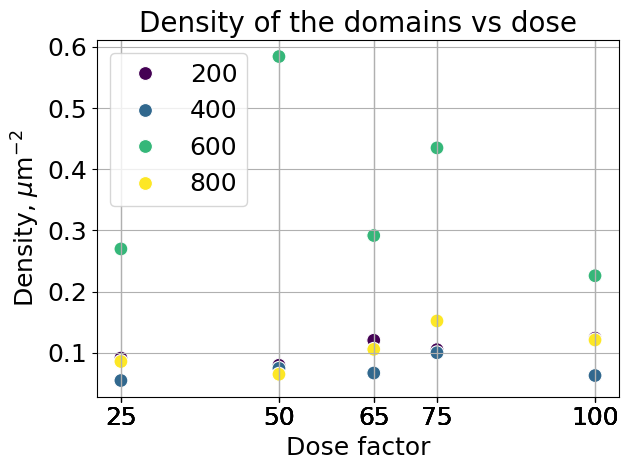

In [31]:
# plot the density of the particles vs dose
plt.figure(
            # figsize=(4, 3),
            # dpi=300
            )
sns.scatterplot(data=density, x='Dose', y='Density', hue='Current', palette='viridis', s=100)
plt.title('Density of the domains vs dose', fontsize=20)
plt.xlabel('Dose factor', fontsize=18)
plt.ylabel('Density, $\mu$m$^{-2}$', fontsize=18)
plt.xticks(density['Dose'], fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='upper left', fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.savefig(save_path + 'density_vs_dose.svg')
plt.show()

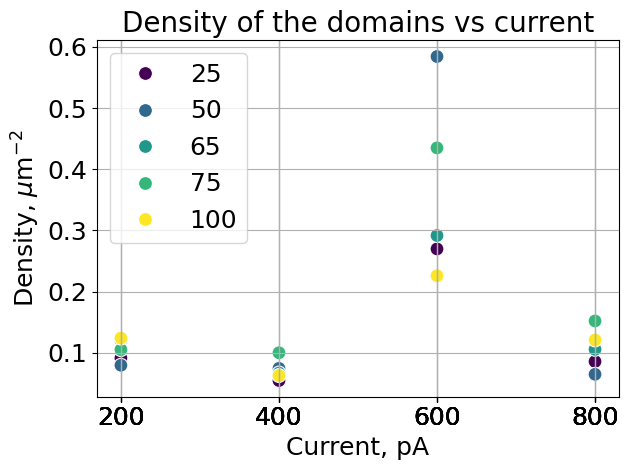

In [33]:
# plot the density of the particles vs current
plt.figure(
            # figsize=(4, 3),
            # dpi=300
            )
sns.scatterplot(data=density, x='Current', y='Density', hue='Dose', palette='viridis', s=100)
plt.title('Density of the domains vs current', fontsize=20)
plt.xlabel('Current, pA', fontsize=18)
plt.ylabel('Density, $\mu$m$^{-2}$', fontsize=18)
plt.xticks(density['Current'], fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='upper left', fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.savefig(save_path + 'density_vs_current.svg')
plt.show()

Make an unique_combinations of dose and current and filter out outliers

In [34]:

# show each unique combination of (dose, current as a matrix)
unique_combinations = combined_df.groupby(['Dose', 'Current']).size().unstack(fill_value=0)
print(f'{unique_combinations}\n')
# dose values as a list
# doses = unique_combinations.index.to_list()
# currents = unique_combinations.columns.to_list()
# print(f'Doses before: {doses}')
# print(f'Currents before: {currents}')

#* remove outliers
# Create a copy of the DataFrame to store the results
df_out = combined_df.copy()


# Apply the function to each group and each column
# for column in columns:
#     if column in combined_df.columns and np.issubdtype(combined_df[column].dtype, np.number):
#         result = combined_df.groupby(['Dose', 'Current'], as_index=False).apply(lambda group: remove_outliers(group, column, 0.25, 0.75) if column in group.columns else group, include_groups=False)

# Group the data by 'Dose' and 'Current' and apply the outlier removal for each group
for column in columns:
    if column in combined_df.columns and np.issubdtype(combined_df[column].dtype, np.number) and column != 'Dose' and column != 'Current':
        # print(f'Column: {column}')
        grouped = df_out.groupby(['Dose', 'Current'])
        cleaned_groups = [remove_outliers2(group) for _, group in grouped]

        # Combine the cleaned groups back into a single dataframe
        cleaned_data_no_outliers = pd.concat(cleaned_groups)

df_out = cleaned_data_no_outliers
# Reset the index of the output DataFrame
df_out.reset_index(drop=True, inplace=True)

#* Sammary of cleaned data at Area_nm
sum_before = combined_df['Area_nm'].describe()
sum_after = df_out['Area_nm'].describe()
print(f'\nArea_nm Before cleaning: {sum_before}')
print(f'Shape before cleaning: {combined_df.shape}\n')
print(f'Area_nm After cleaning: {sum_after}')
print(f'\nShape after cleaning: {df_out.shape}\n')



#*###################

unique_combinations = df_out.groupby(['Dose', 'Current']).size().unstack(fill_value=0)
print(f'UC after: {unique_combinations}')
# dose values as a list
doses = unique_combinations.index.to_list()
currents = unique_combinations.columns.to_list()
print(f'\nCheck values after cleaning')
print(f'\nDoses after: {doses}')
print(f'\nCurrents after: {currents}')
# sum cell values for the same combinations (dose, current)
# combined_df_sum = combined_df.groupby(['Dose', 'Current']).sum().reset_index()



Current  200  400   600  800
Dose                        
25       179  107   529  168
50       156  146  1146  127
65       236  131   572  207
75       206  196   853  298
100      243  123   443  237


Area_nm Before cleaning: count    6.303000e+03
mean     1.013445e+05
std      9.818056e+04
min      7.480492e+03
25%      4.787515e+04
50%      7.281012e+04
75%      1.196879e+05
max      1.825240e+06
Name: Area_nm, dtype: float64
Shape before cleaning: (6303, 15)

Area_nm After cleaning: count      6094.000000
mean      92644.841592
std       73248.404609
min        7480.491979
25%       47376.449203
50%       70316.624607
75%      112207.379692
max      700174.049276
Name: Area_nm, dtype: float64

Shape after cleaning: (6094, 15)

UC after: Current  200  400   600  800
Dose                        
25       177  102   524  165
50       149  139  1132  122
65       224  123   554  198
75       192  188   820  280
100      228  122   426  229

Check values after cleaning

Doses after: 

Save filtered df and assign to the original df

In [35]:
# if everything is ok, save the cleaned data to a csv file
df_out.to_csv(save_path + 'cleaned_data.csv', index=False)
# assign the dataframe back to the original name
combined_df = df_out

Plot histogram and KDE plot for each combination of dose and current

In [36]:
%matplotlib inline
# Assuming 'combined_df' is your DataFrame and it includes 'Dose', 'Current', and size metric columns

# Aggregate data for plotting
aggregated_data = combined_df.groupby(['Dose', 'Current'])

# plt.figure(figsize=(10, 6))
n_doses, n_currents = unique_combinations.shape
fig_dose_current, ax_dose_current = plt.subplots(n_doses, n_currents, figsize=(22, 24), dpi=600)

# For plotting histograms + KDE of all measurements for each combination
for (dose, current), group in aggregated_data: 

    # plot histogram and KDE for each group
    # calculate indices for subplot
    dose_index = np.where(unique_combinations.index == dose)[0][0]
    current_index = np.where(unique_combinations.columns == current)[0][0]
    sns.histplot(x=group['Area_nm']/1e6, 
                kde=True,
                stat='density',
                common_norm=False,
                shrink=0.9,
                label=f"Dose {dose}, Current {current}", 
                ax=ax_dose_current[dose_index, current_index])
    ax_dose_current[dose_index, current_index].set_title(f"PDF + KDE: Dose {dose}, Current {current}", fontsize=18, fontweight='bold')
    ax_dose_current[dose_index, current_index].set_ylabel('Density', fontsize=20)
    ax_dose_current[dose_index, current_index].set_xlabel('Area, $\\mathrm{µm}^2$', fontsize=20)
    ax_dose_current[dose_index, current_index].tick_params(axis='both', which='major', labelsize=16)
    # calculate mean
    mean = group['Area_nm'].mean()
    ax_dose_current[dose_index, current_index].axvline(mean/1e6, color='r', linestyle='--', label=f'Mean: {mean/1e6:.2f} $\\mathrm{{µm}}^2$')
    # calculate median
    median = group['Area_nm'].median()
    ax_dose_current[dose_index, current_index].axvline(median/1e6, color='g', linestyle='--', label=f'Median: {median/1e6:.2f} $\\mathrm{{µm}}^2$')
    # calculate mode
    mode = group['Area_nm'].mode().values[0]
    ax_dose_current[dose_index, current_index].axvline(mode/1e6, color='b', linestyle='--', label=f'Mode: {mode/1e6:.2f} $\\mathrm{{µm}}^2$')
    # calculate standard deviation
    std = group['Area_nm'].std()
    ax_dose_current[dose_index, current_index].axvline(mean/1e6 + std/1e6, color='k', linestyle='--', label=f'$\pm 1\sigma$: {std/1e6:.2f} $\\mathrm{{µm}}^2$')
    # add legend
    ax_dose_current[dose_index, current_index].legend(fontsize=12, loc='upper right')
    plt.tight_layout()
# # save the plot
plt.savefig(save_path + 'PSD_dose_current.png', dpi=600)
plt.show()

Plot hist and KDE for each combination of dose and current at separate plots

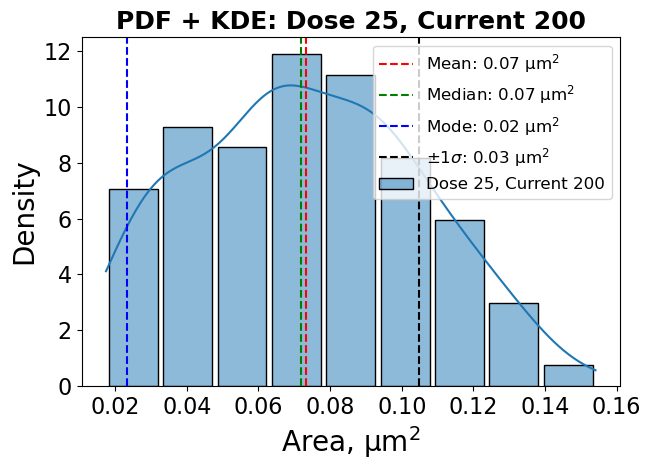

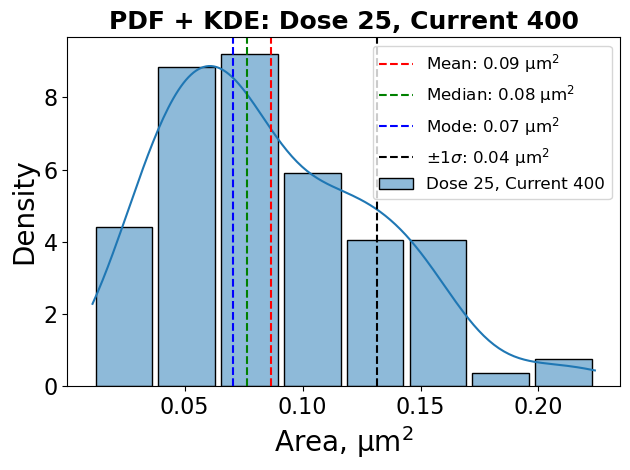

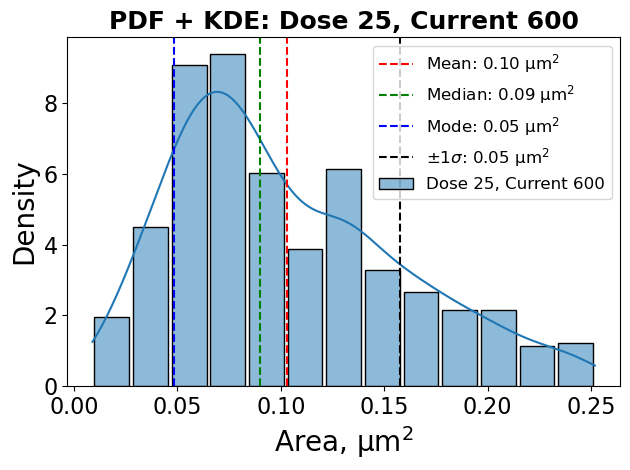

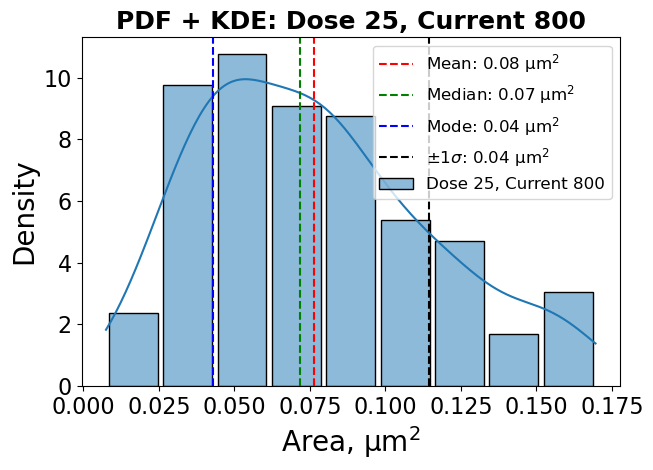

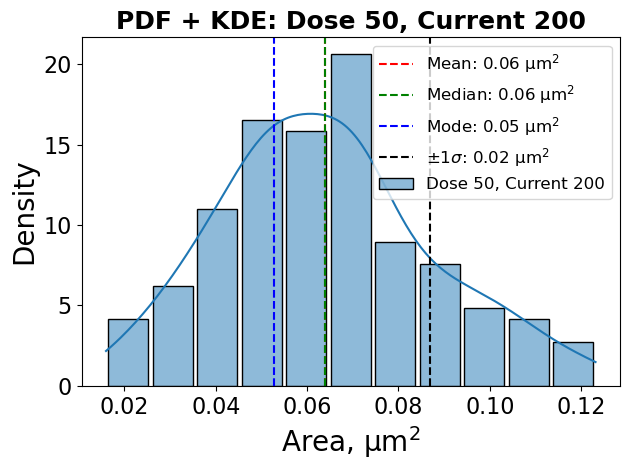

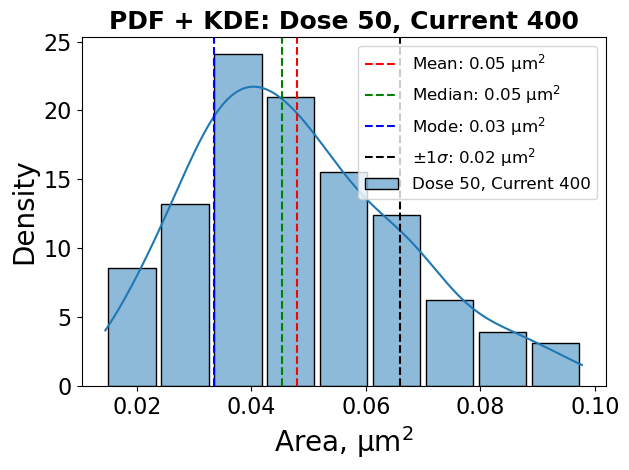

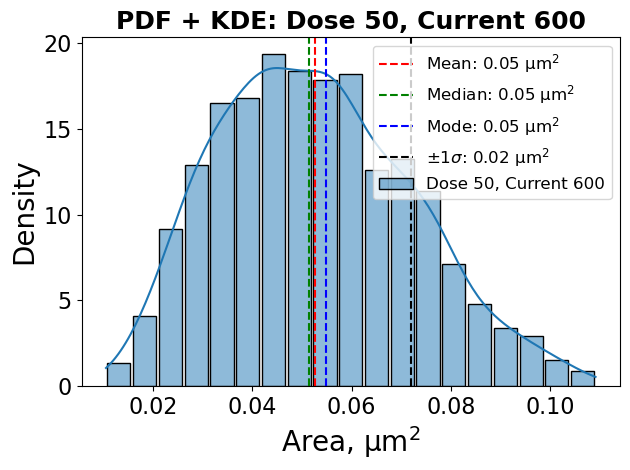

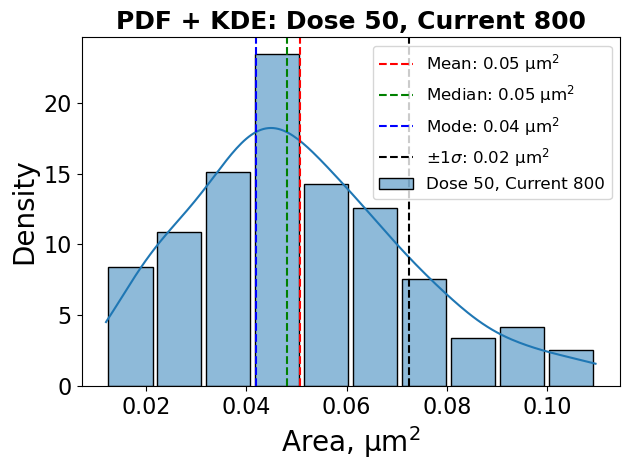

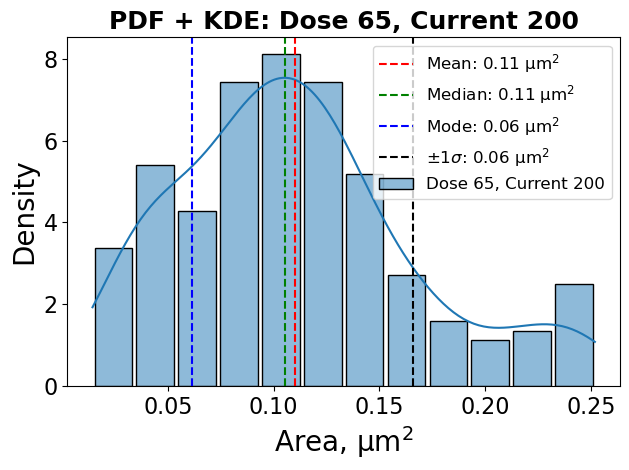

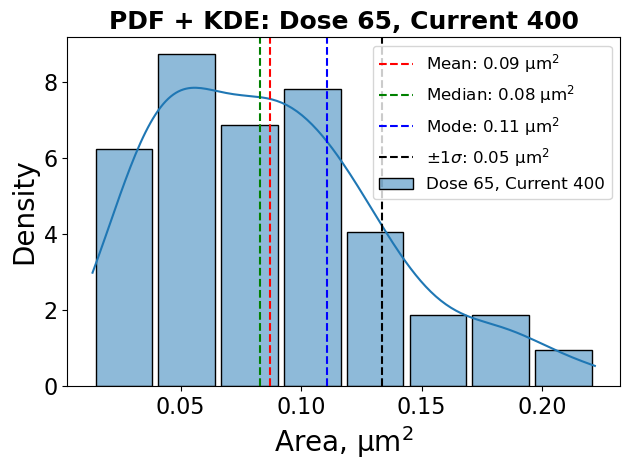

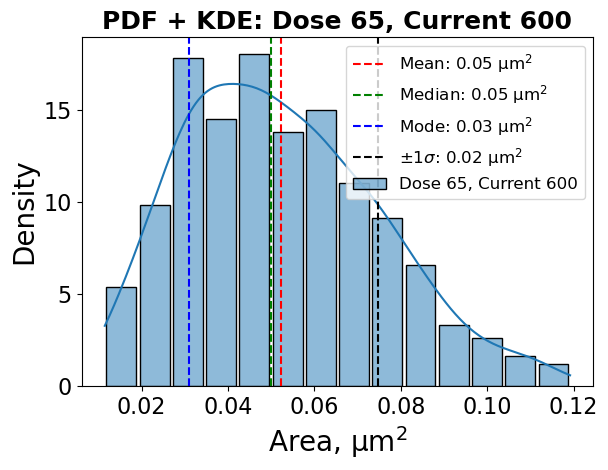

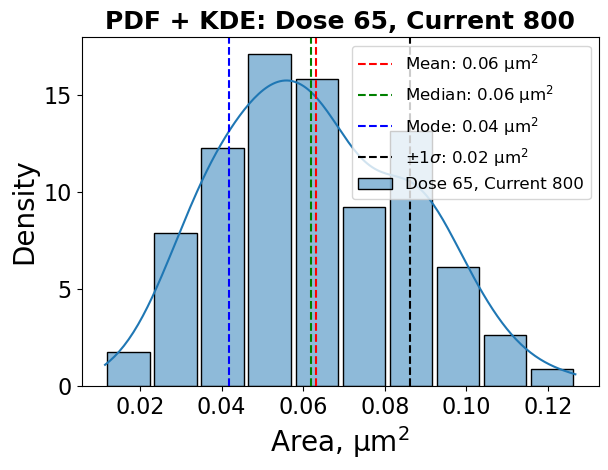

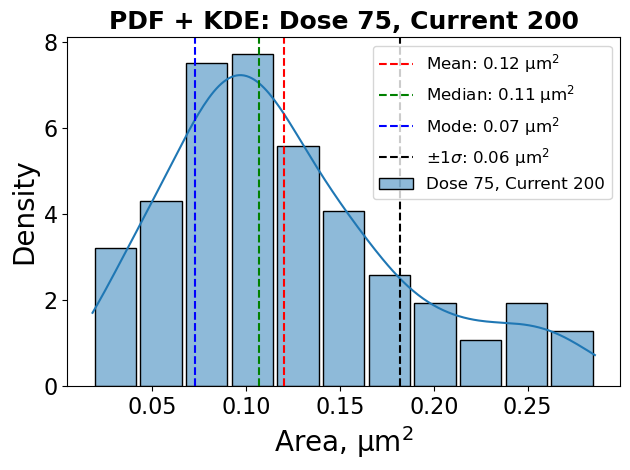

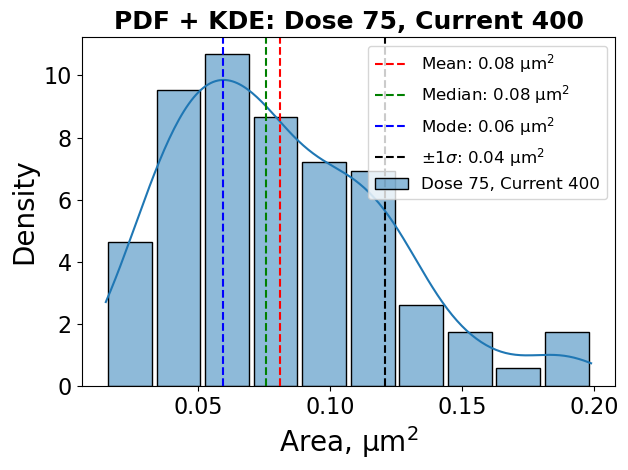

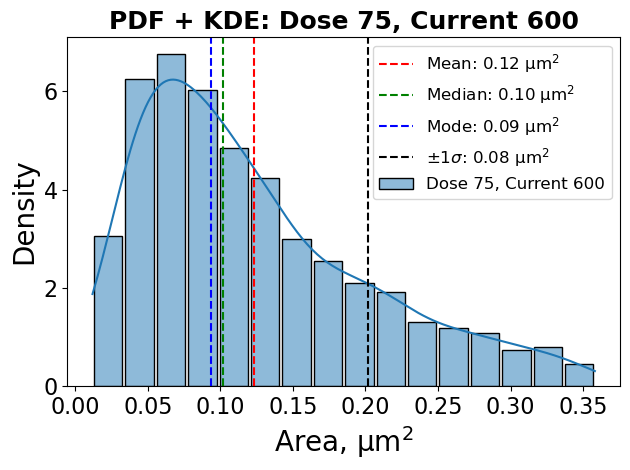

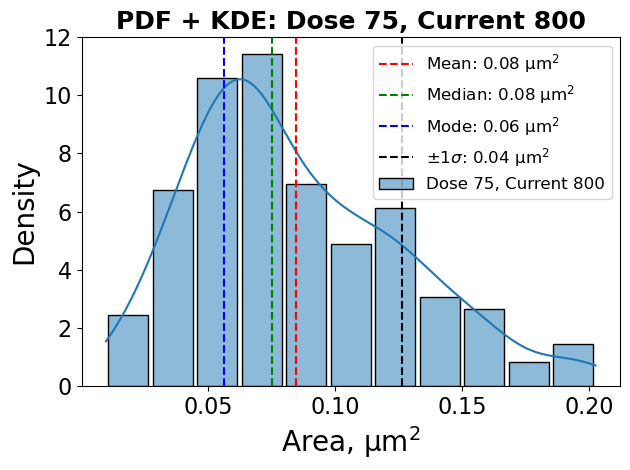

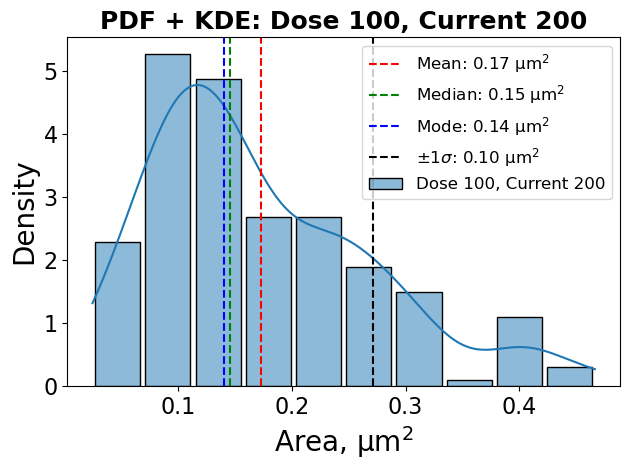

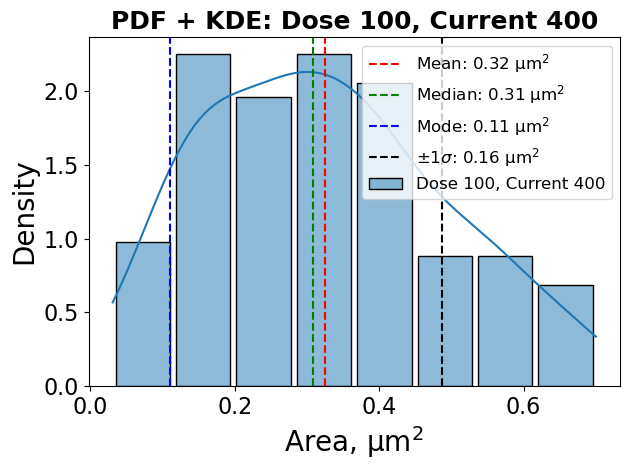

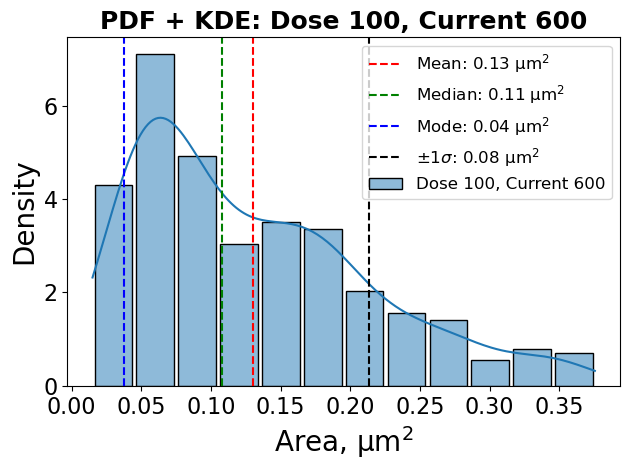

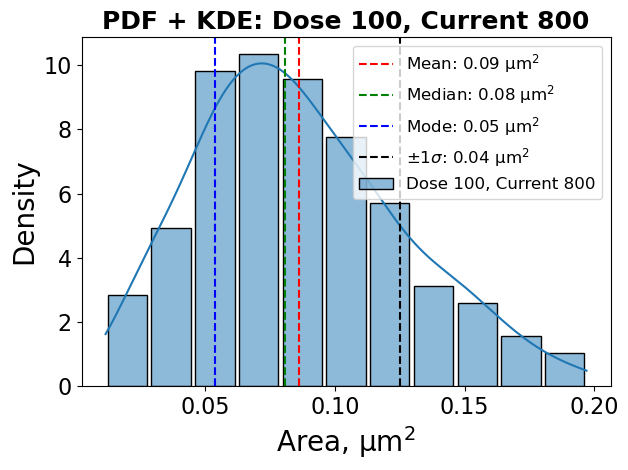

In [37]:
# path to save separate plots
path_sep_hists = make_folder(save_path, 'Hists_dose_current')
# Aggregate data for plotting
aggregated_data = combined_df.groupby(['Dose', 'Current'])

# plt.figure(figsize=(10, 6))
n_doses, n_currents = unique_combinations.shape

# For plotting histograms + KDE of all measurements for each combination
for (dose, current), group in aggregated_data:
    # plot histogram and KDE for each group
    sns.histplot(x=group['Area_nm']/1e6, 
                kde=True,
                stat='density',
                common_norm=False,
                shrink=0.9,
                label=f"Dose {dose}, Current {current}")
    plt.title(f"PDF + KDE: Dose {dose}, Current {current}", fontsize=18, fontweight='bold')
    plt.ylabel('Density', fontsize=20)
    plt.xlabel('Area, $\\mathrm{µm}^2$', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=16)
    # calculate mean
    mean = group['Area_nm'].mean()
    plt.axvline(mean/1e6, color='r', linestyle='--', label=f'Mean: {mean/1e6:.2f} $\\mathrm{{µm}}^2$')
    # calculate median
    median = group['Area_nm'].median()
    plt.axvline(median/1e6, color='g', linestyle='--', label=f'Median: {median/1e6:.2f} $\\mathrm{{µm}}^2$')
    # calculate mode
    mode = group['Area_nm'].mode().values[0]
    plt.axvline(mode/1e6, color='b', linestyle='--', label=f'Mode: {mode/1e6:.2f} $\\mathrm{{µm}}^2$')
    # calculate standard deviation
    std = group['Area_nm'].std()
    plt.axvline(mean/1e6 + std/1e6, color='k', linestyle='--', label=f'$\pm 1\sigma$: {std/1e6:.2f} $\\mathrm{{µm}}^2$')
    # add legend
    plt.legend(fontsize=12, loc='upper right')
    plt.tight_layout()
    # save the plot
    plt.savefig(path_sep_hists + f'Hists_dose_{dose}_current_{current}.png', dpi=600)
    plt.show()

Plot the histograms of the particle size distribution for each unique combination of dose and current but on the same plot vs dose

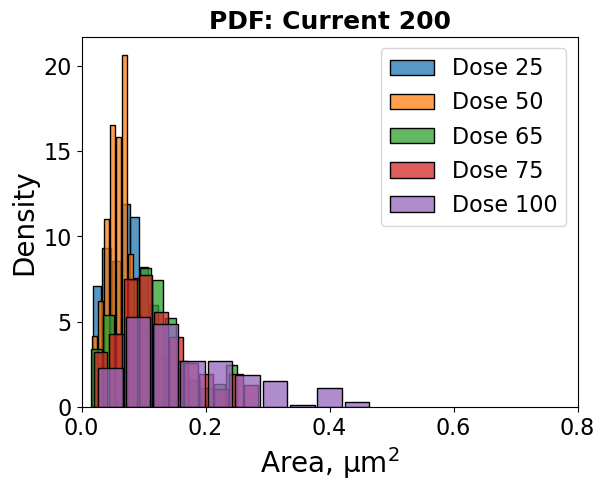

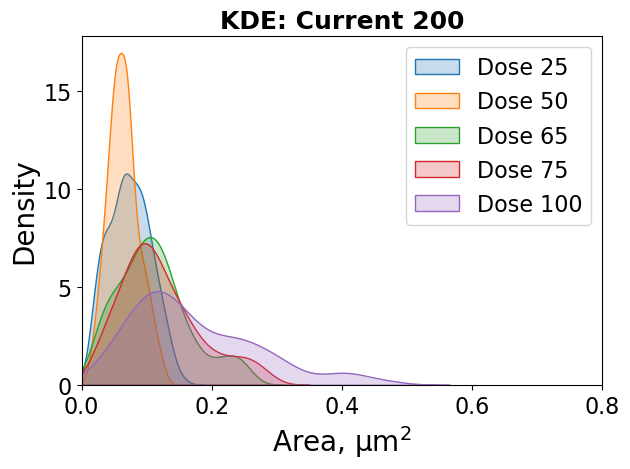

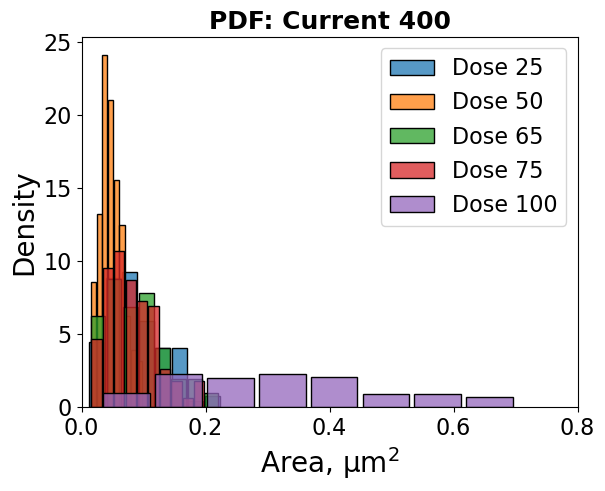

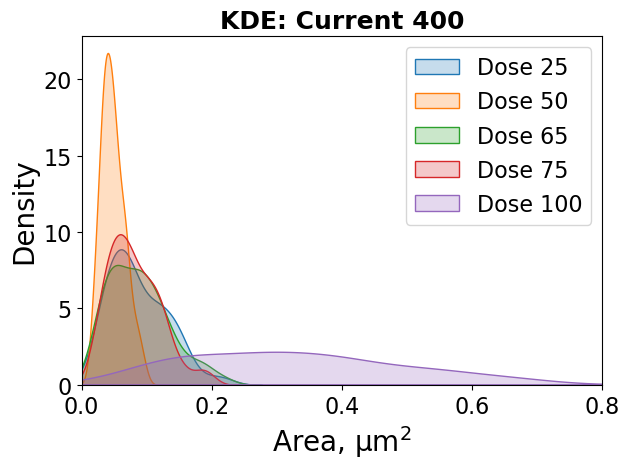

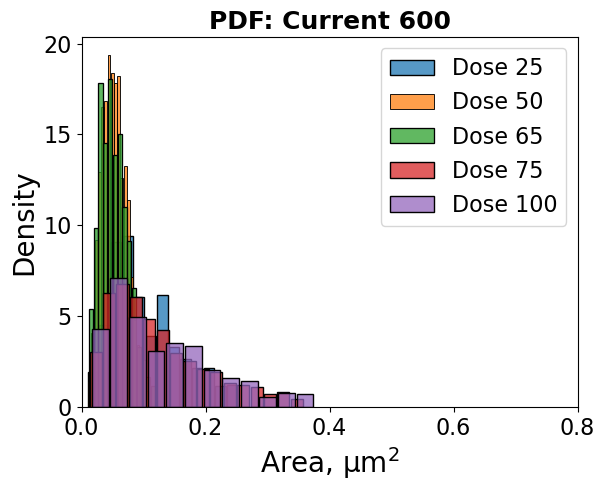

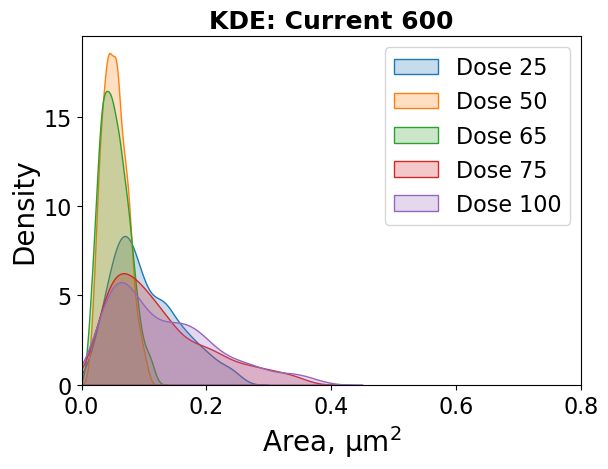

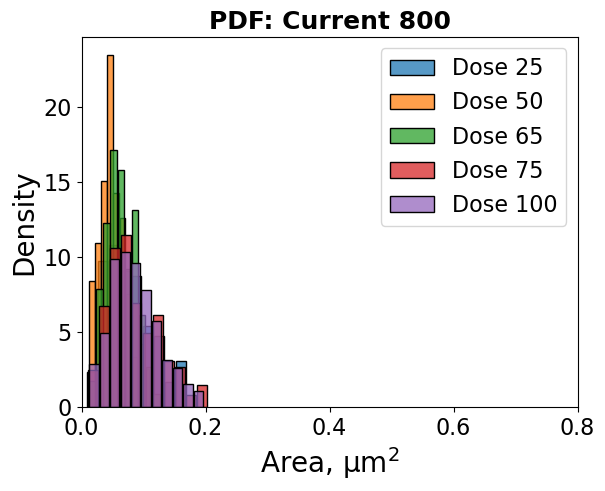

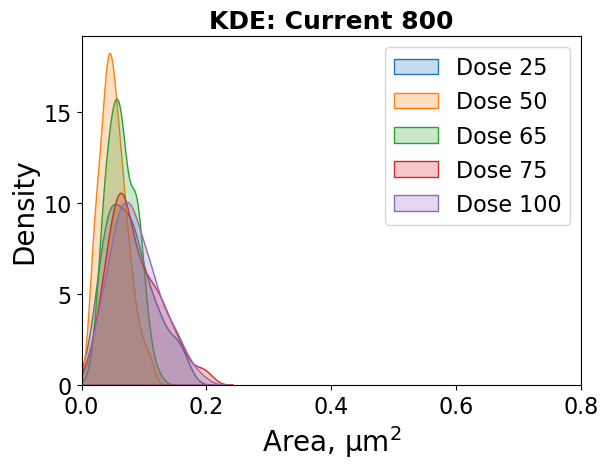

In [57]:
path_accum_doses = make_folder(save_path, 'Accum_doses')
# Aggregate data for plotting
aggregated_data = combined_df.groupby('Current')
plots_type = ['PDF', 'KDE']
# For plotting histograms + KDE of all measurements for each combination
for current, group in aggregated_data: 
    fig1, ax = plt.subplots()
    fig2, ax2 = plt.subplots()
    for dose in doses:
        # filter data for the current dose
        dose_data = group[group['Dose'] == dose]

        # plot histogram and KDE for each group
        sns.histplot(x=dose_data['Area_nm']/1e6, 
                    # kde=True,
                    stat='density',
                    common_norm=False,
                    shrink=0.9,
                    label=f"Dose {dose}", 
                    ax=ax)
        sns.kdeplot(x=dose_data['Area_nm']/1e6, 
                    label=f"Dose {dose}", 
                    ax=ax2,
                    fill=True)
    for ax_, plot_type, fig in zip([ax, ax2], plots_type, [fig1, fig2]):
        ax_.set_title(f"{plot_type}: Current {current}", fontsize=18, fontweight='bold')
        ax_.set_ylabel('Density', fontsize=20)
        ax_.set_xlabel('Area, $\\mathrm{µm}^2$', fontsize=20)
        ax_.tick_params(axis='both', which='major', labelsize=16)
        ax_.legend(fontsize=16, loc='upper right')
        ax_.set_xlim(0, 0.8)
        plt.tight_layout()
        fig.savefig(path_accum_doses + f'{plot_type}_hists_var_car_{current}.png', dpi=600)
    plt.show()

Plot the histograms of the particle size distribution for each unique combination of dose and current but on the same plot vs current 

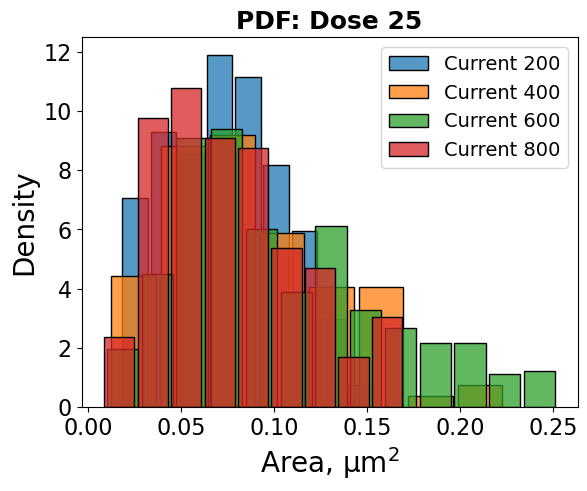

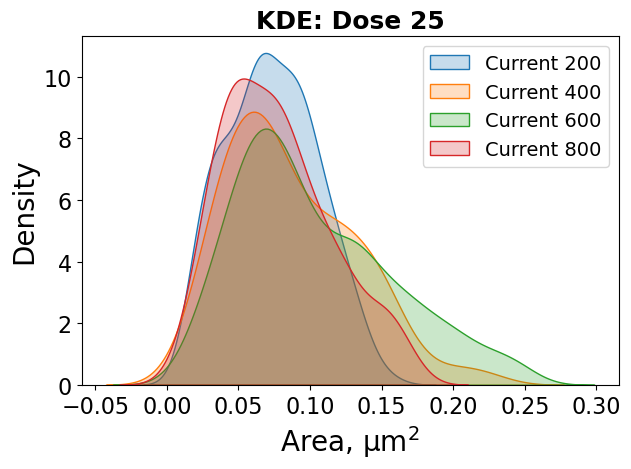

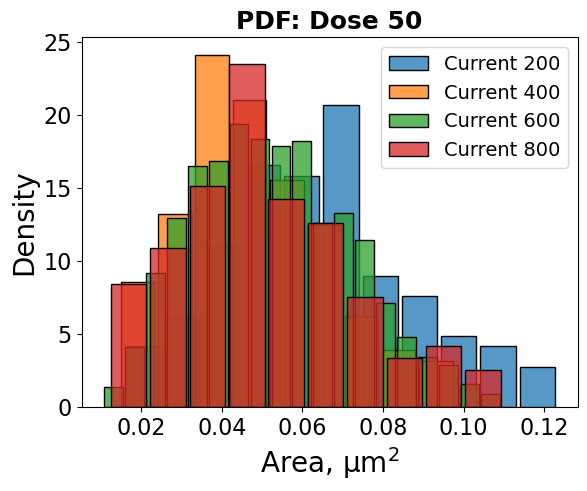

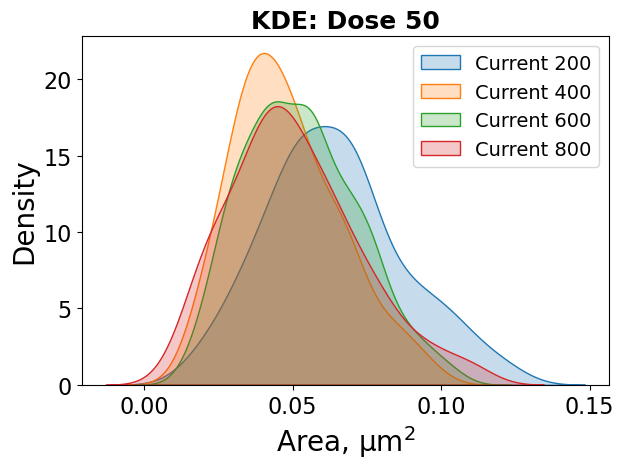

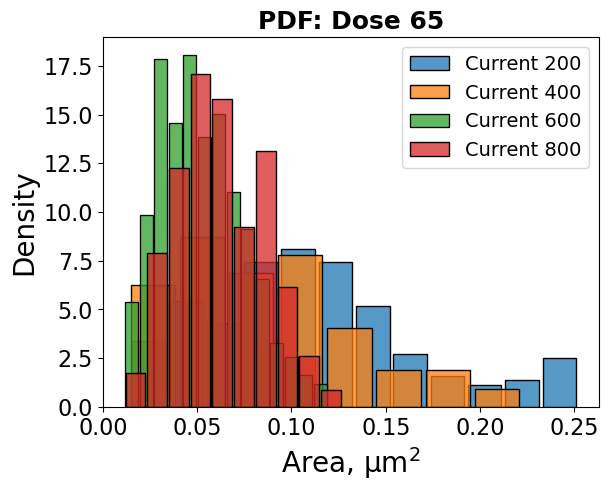

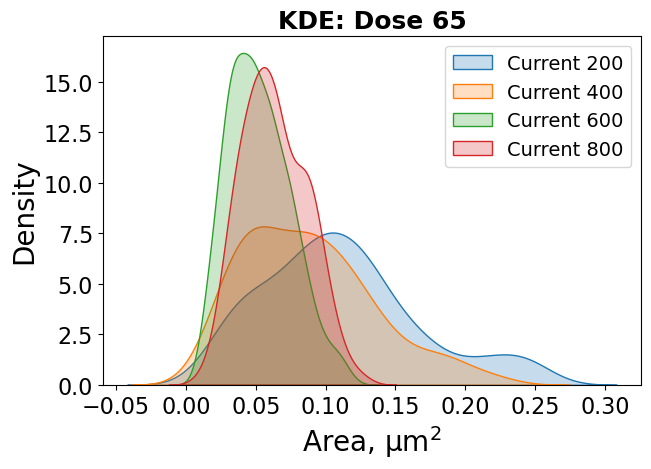

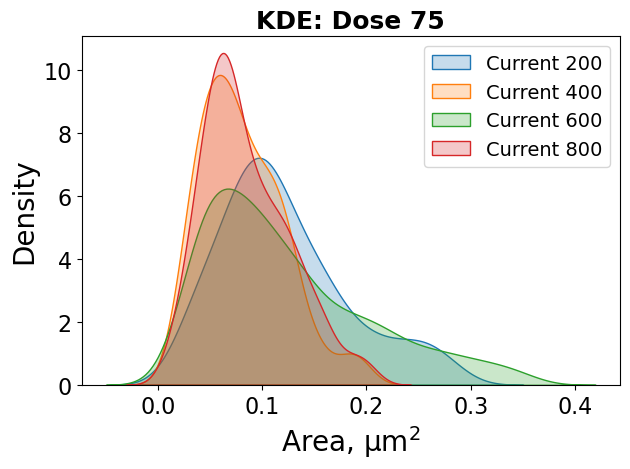

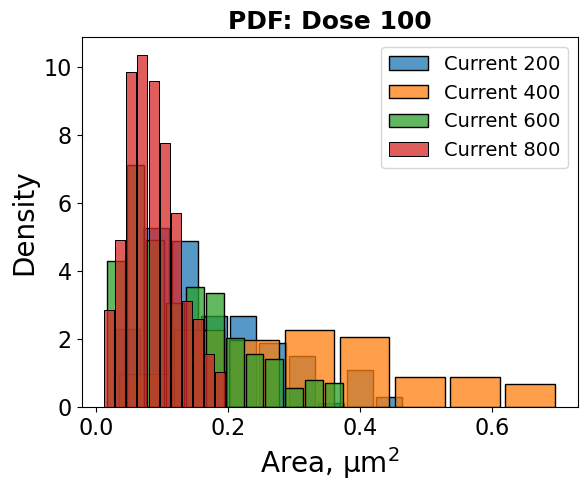

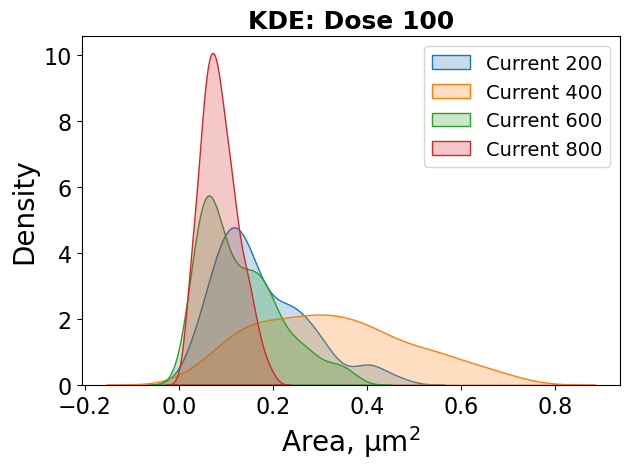

In [40]:
path_accum_currents = make_folder(save_path, 'Accum_currents')
# Aggregate data for plotting
aggregated_data = combined_df.groupby('Dose')
plots_type = ['PDF', 'KDE']
# For plotting histograms + KDE of all measurements for each combination
for dose, group in aggregated_data: 
    fig1, ax = plt.subplots()
    fig2, ax2 = plt.subplots()
    for current in currents:
        # filter data for the current current
        current_data = group[group['Current'] == current]

        # plot histogram and KDE for each group
        sns.histplot(x=current_data['Area_nm']/1e6, 
                    # kde=True,
                    stat='density',
                    common_norm=False,
                    shrink=0.9,
                    label=f"Current {current}", 
                    ax=ax)
        sns.kdeplot(x=current_data['Area_nm']/1e6, 
                    label=f"Current {current}",
                    fill=True,
                    ax=ax2)
    for ax_, plot_type, fig in zip([ax, ax2], plots_type, [fig1, fig2]):
        ax_.set_title(f"{plot_type}: Dose {dose}", fontsize=18, fontweight='bold')
        ax_.set_ylabel('Density', fontsize=20)
        ax_.set_xlabel('Area, $\\mathrm{µm}^2$', fontsize=20)
        ax_.tick_params(axis='both', which='major', labelsize=16)
        ax_.legend(fontsize=14, loc='upper right')
        plt.tight_layout()
        fig.savefig(path_accum_currents + f'{plot_type}_hists_var_DF_{dose}.png', dpi=600)
    plt.show()

Plot histograms for each dose on the same plot consider there is no dependence on current 

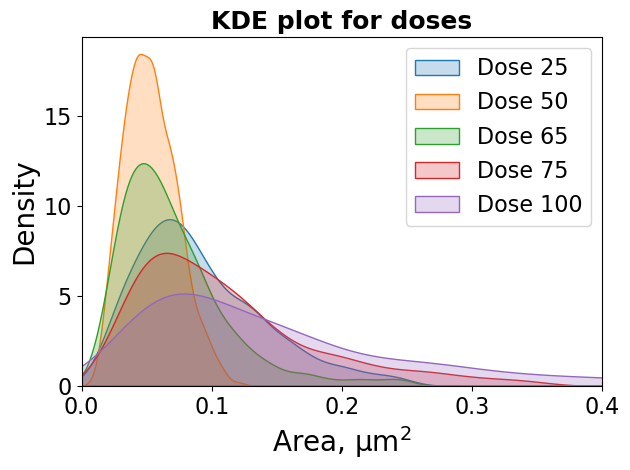

In [41]:
#* plot histograms for each dose on the same plot consider there is no dependence on current 

# Aggregate data for plotting
aggregated_data = combined_df.groupby('Dose')
# plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()
# For plotting histograms + KDE of all measurements for each combination
for dose, group in aggregated_data: 
    # plot histogram and KDE for each group
    # sns.histplot(x=group['Area_nm']/1e6, 
    #             kde=True,
    #             stat='density',
    #             common_norm=False,
    #             shrink=0.9,
    #             label=f"Dose {dose}", 
    #             ax=ax)
    sns.kdeplot(x=group['Area_nm']/1e6, 
                    label=f"Dose {dose}",
                    fill=True,
                    ax=ax)
    ax.set_title(f"KDE plot for doses", fontsize=18, fontweight='bold')
    ax.set_ylabel('Density', fontsize=20)
    ax.set_xlabel('Area, $\\mathrm{µm}^2$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xlim(0, 0.4)
    # add legend
    ax.legend(fontsize=16, loc='upper right')
    plt.tight_layout()
    # save the plot
    plt.savefig(path_accum_currents + f'KDE_doses_no_cur_dep.png', dpi=600)

Plot histograms for each curret on the same plot consider there is no dependence on dose 

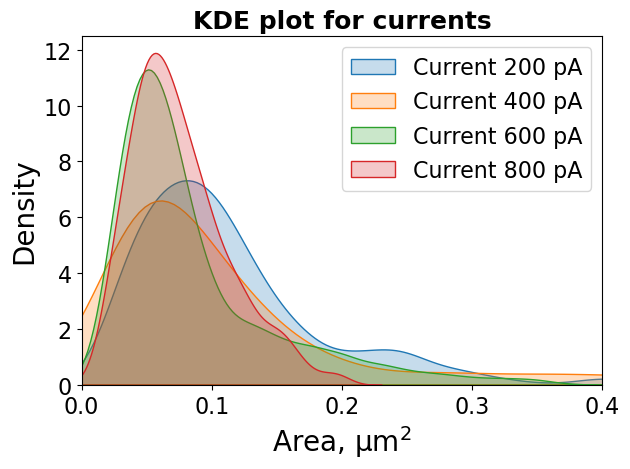

In [42]:
#* plot histograms for each curret on the same plot consider there is no dependence on dose 
# Aggregate data for plotting
aggregated_data = combined_df.groupby('Current')
# plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()
# For plotting histograms + KDE of all measurements for each combination
for current, group in aggregated_data: 
    # plot histogram and KDE for each group
    # sns.histplot(x=group['Area_nm']/1e6, 
    #             kde=True,
    #             stat='density',
    #             common_norm=False,
    #             shrink=0.9,
    #             label=f"Dose {dose}", 
    #             ax=ax)
    sns.kdeplot(x=group['Area_nm']/1e6, 
                    label=f"Current {current} pA",
                    fill=True,
                    ax=ax)
    ax.set_title(f"KDE plot for currents", fontsize=18, fontweight='bold')
    ax.set_ylabel('Density', fontsize=20)
    ax.set_xlabel('Area, $\\mathrm{µm}^2$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xlim(0, 0.4)
    # add legend
    ax.legend(fontsize=16, loc='upper right')
    plt.tight_layout()
    # save the plot
    plt.savefig(save_path + f'KDE_current_no_dose_dep.png', dpi=600)

Bar lot of Area_nm for Doses summing over all currents

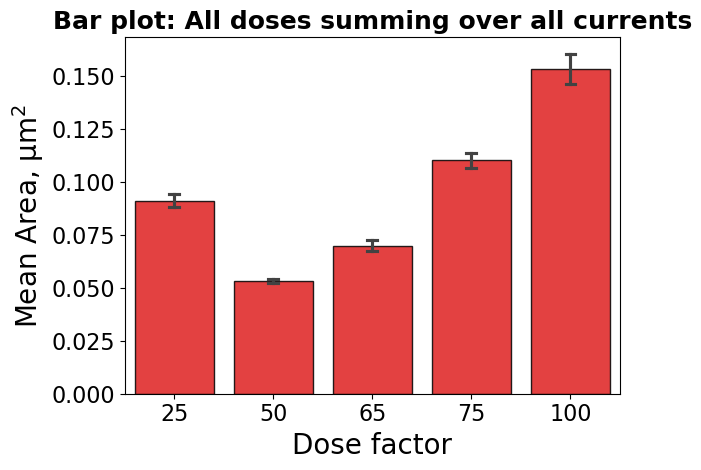

In [43]:
#* make bar lot of Area_nm for Doses summing over all currents
#* recalcultes Area_nm to µm^2 
comb_dfArea_nm = combined_df.copy()
comb_dfArea_nm['Area_nm'] = comb_dfArea_nm['Area_nm']/1e6
#plot
fig, ax = plt.subplots()
sns.barplot(x='Dose', 
            y='Area_nm', 
            data=comb_dfArea_nm, 
            ax=ax,
            estimator='mean',
            color='red',
            alpha=0.85,
            edgecolor='black',
            errorbar=('ci'),
            capsize=0.1
            )
ax.set_title(f"Bar plot: All doses summing over all currents", fontsize=18, fontweight='bold')
ax.set_ylabel('Mean Area, $\\mathrm{µm}^2$', fontsize=20)
ax.set_xlabel('Dose factor', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
# ax.legend(fontsize=12, loc='upper right')
plt.tight_layout()
fig.savefig(save_path + f'barplot_all_doses_summing_over_all_currents.png', dpi=600)

plt.show()

Box lot of Area_nm for Doses summing over all currents

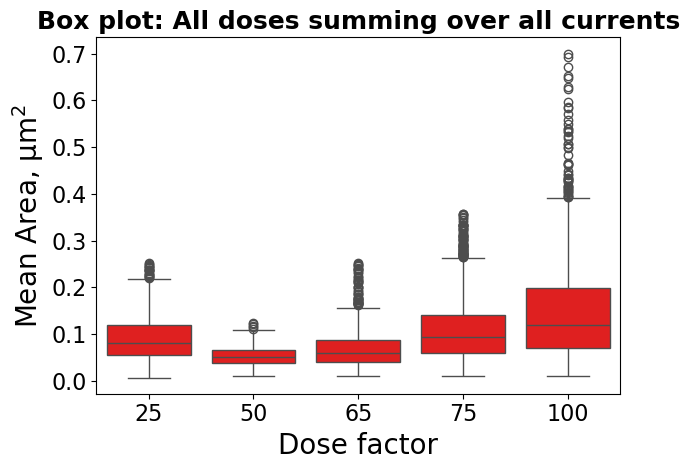

In [44]:
# box plot fot the same as above
fig, ax = plt.subplots()
sns.boxplot(x='Dose', 
            y='Area_nm', 
            data=comb_dfArea_nm, 
            ax=ax,
            color='red',
            # estimator='mean',
            # # palette='plasma',
            # errorbar=('ci'),
            # capsize=0.1
            )
ax.set_title(f"Box plot: All doses summing over all currents", fontsize=18, fontweight='bold')
ax.set_ylabel('Mean Area, $\\mathrm{µm}^2$', fontsize=20)
ax.set_xlabel('Dose factor', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
# log y scale
# ax.set_yscale('log')
# ax.legend(fontsize=12, loc='upper right')
plt.tight_layout()
fig.savefig(save_path + f'Boxplot_all_doses_summing_over_all_currents.png', dpi=600)

plt.show()

Bar plot of Area_nm for Doses summing over all currents

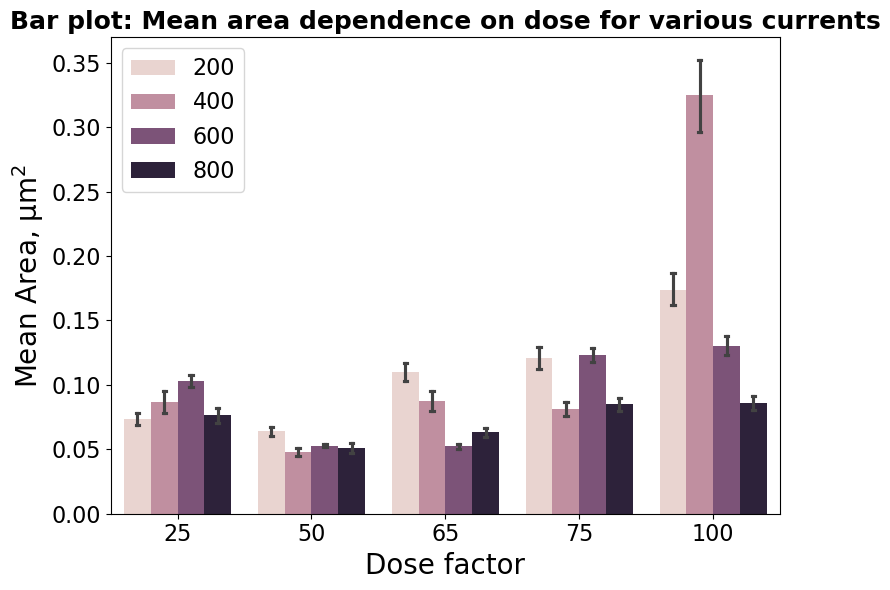

In [45]:
#* make bar plot of Area_nm for Doses summing over all currents
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x='Dose', 
            y='Area_nm', 
            data=comb_dfArea_nm, 
            ax=ax,
            estimator='mean',
            hue='Current',
            # palette='plasma',
            errorbar=('ci'),
            capsize=0.1,
            )
ax.set_title(f"Bar plot: Mean area dependence on dose for various currents", 
fontsize=18, fontweight='bold')
ax.set_ylabel('Mean Area, $\\mathrm{µm}^2$', fontsize=20)
ax.set_xlabel('Dose factor', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=16, loc='upper left')
plt.tight_layout()
fig.savefig(save_path + f'Barplots_all_doses_for_each_current.png', dpi=600)

plt.show()

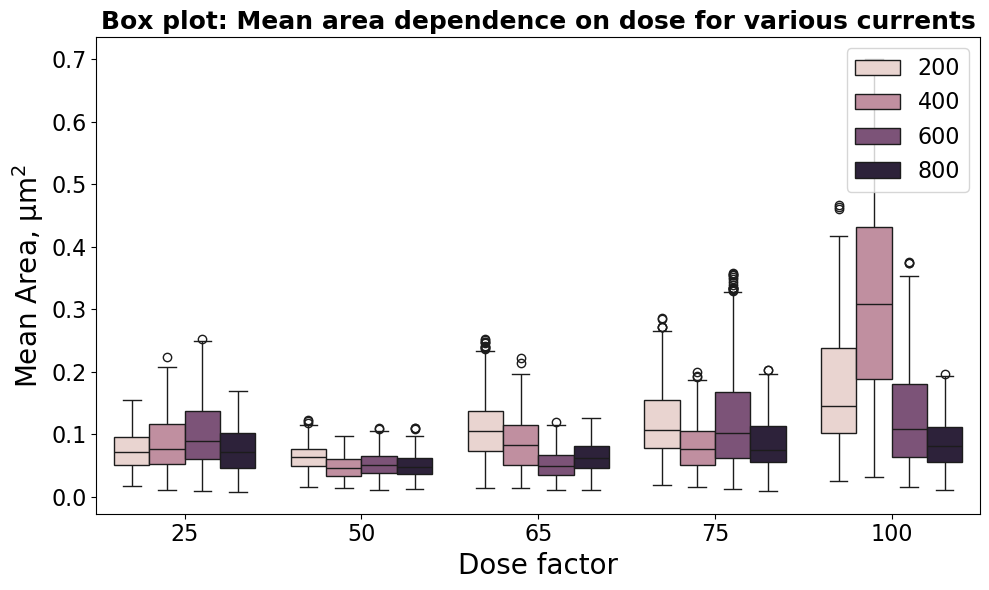

In [46]:
#* make bar olot of Area_nm for Currents summing over all doses
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='Dose', 
            y='Area_nm',
            data=comb_dfArea_nm, 
            ax=ax,
            hue='Current',
            )
ax.set_title(f"Box plot: Mean area dependence on dose for various currents", fontsize=18, fontweight='bold')
ax.set_ylabel('Mean Area, $\\mathrm{µm}^2$', fontsize=20)
ax.set_xlabel('Dose factor', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=16, loc='upper right')
# ax.set_yscale('log')
plt.tight_layout()
fig.savefig(save_path + f'boxplot_all_all_doses_for_each_current.png', dpi=600)

plt.show()

Violine olot of Area_nm for doses for each current

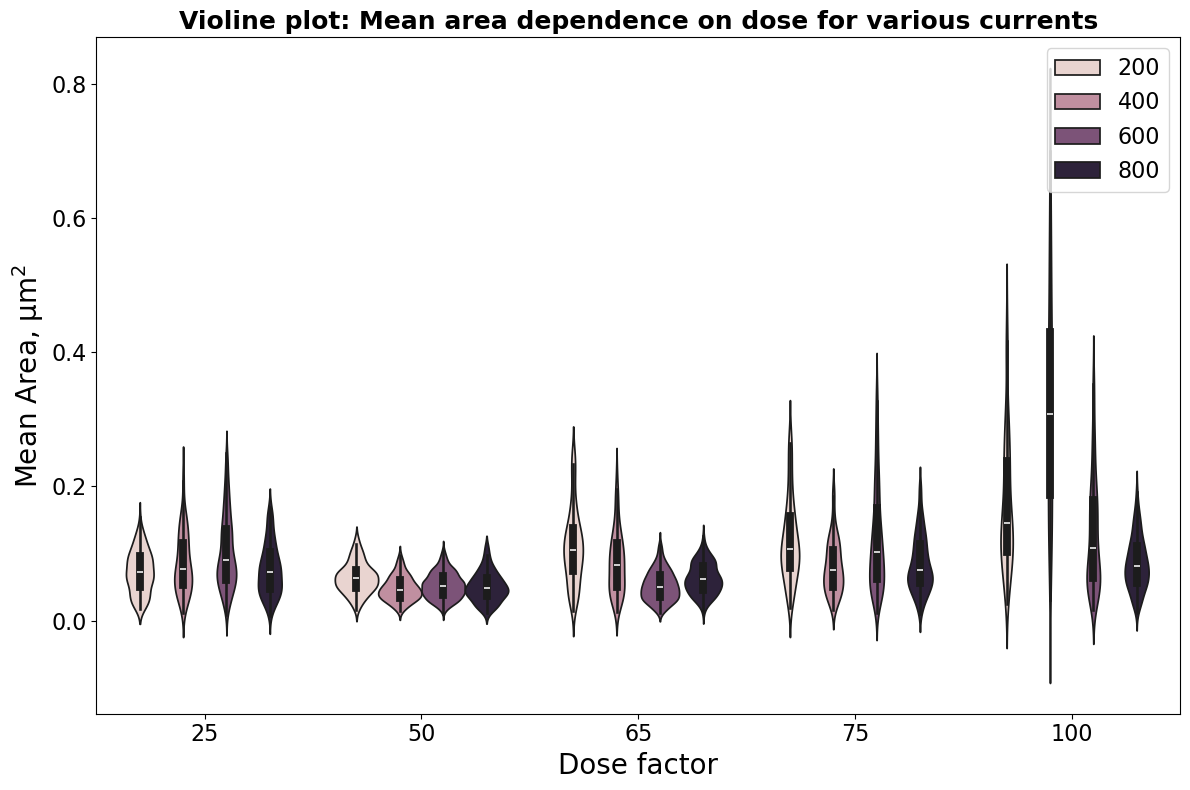

In [47]:
#* make violine olot of Area_nm for doses for each current
fig, ax = plt.subplots(figsize=(12, 8))
sns.violinplot(x='Dose', 
            y='Area_nm',
            data=comb_dfArea_nm, 
            ax=ax,
            hue='Current',
            # errorbar=('ci'),
            # capsize=0.2
            )
ax.set_title(f"Violine plot: Mean area dependence on dose for various currents", fontsize=18, fontweight='bold')
ax.set_ylabel('Mean Area, $\\mathrm{µm}^2$', fontsize=20)
ax.set_xlabel('Dose factor', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=16, loc='upper right')
plt.tight_layout()
fig.savefig(save_path + f'violineplots_all_doses_for_each_current.png', dpi=600)

plt.show()

Bar olot of Area_nm for Currents summing over all doses

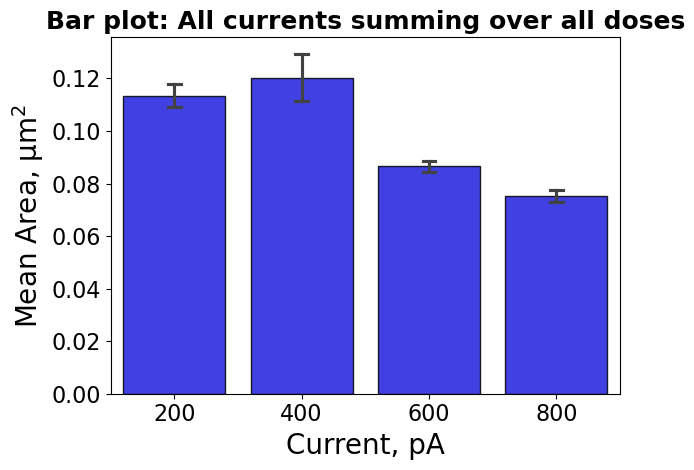

In [48]:
#* make bar olot of Area_nm for Currents summing over all doses
fig, ax = plt.subplots()
sns.barplot(x='Current', 
            y='Area_nm', 
            data=comb_dfArea_nm, 
            ax=ax,
            estimator='mean',
            color='blue',
            alpha=0.85,
            edgecolor='black',
            errorbar=('ci'),
            capsize=0.1
            )
ax.set_title(f"Bar plot: All currents summing over all doses", fontsize=18, fontweight='bold')
ax.set_ylabel('Mean Area, $\\mathrm{µm}^2$', fontsize=20)
ax.set_xlabel('Current, pA', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
# ax.legend(fontsize=12, loc='upper right')
plt.tight_layout()
fig.savefig(save_path + f'barplot_all_doses_summing_over_all_doses.png', dpi=600)

plt.show()

Boxplot all doses summing over_all currents

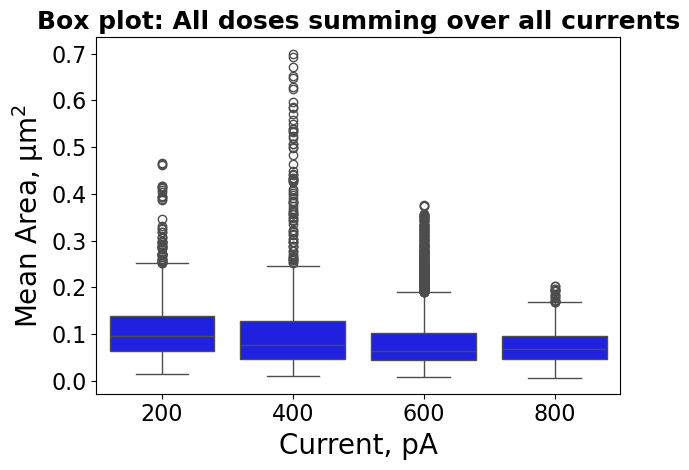

In [49]:
# box plot fot the same as above
fig, ax = plt.subplots()
sns.boxplot(x='Current', 
            y='Area_nm', 
            data=comb_dfArea_nm, 
            ax=ax,
            color='blue',
            # estimator='mean',
            # # palette='plasma',
            # errorbar=('ci'),
            # capsize=0.1
            )
ax.set_title(f"Box plot: All doses summing over all currents", fontsize=18, fontweight='bold')
ax.set_ylabel('Mean Area, $\\mathrm{µm}^2$', fontsize=20)
ax.set_xlabel('Current, pA', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
# log y scale
# ax.set_yscale('log')
# ax.legend(fontsize=12, loc='upper right')
plt.tight_layout()
fig.savefig(save_path + f'Boxplot_all_doses_summing_over_all_doses.png', dpi=600)

plt.show()

Barplots all currents for each doses

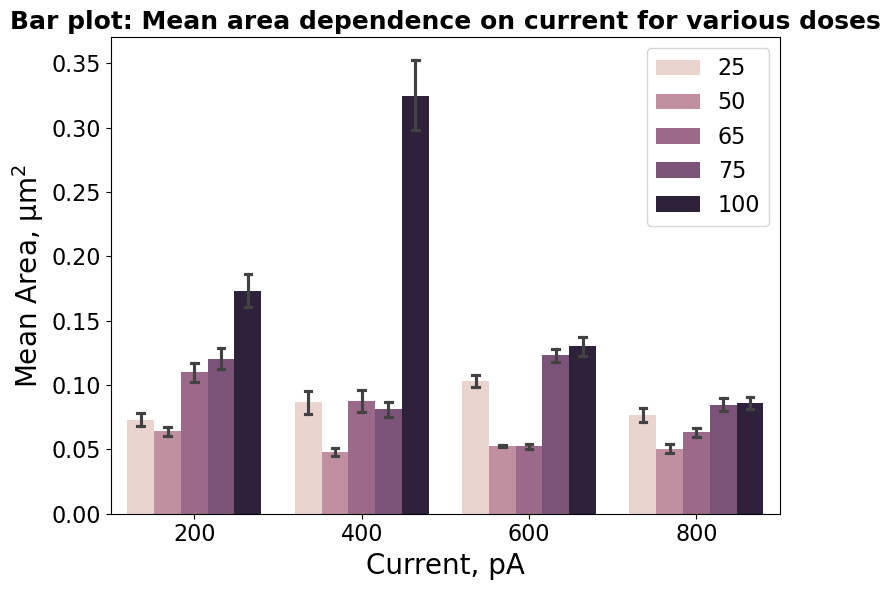

In [50]:
#* make bar olot of Area_nm for Currents for each doses
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x='Current', 
            y='Area_nm',
            data=comb_dfArea_nm, 
            ax=ax,
            hue='Dose',
            errorbar=('ci'),
            capsize=0.2
            )
ax.set_title(f"Bar plot: Mean area dependence on current for various doses", fontsize=18, fontweight='bold')
ax.set_ylabel('Mean Area, $\\mathrm{µm}^2$', fontsize=20)
ax.set_xlabel('Current, pA', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=16, loc='upper right')
plt.tight_layout()
fig.savefig(save_path + f'barplots_all_currents_for_each_doses.png', dpi=600)

plt.show()

Violine plot of Area_nm for Currents for each doses

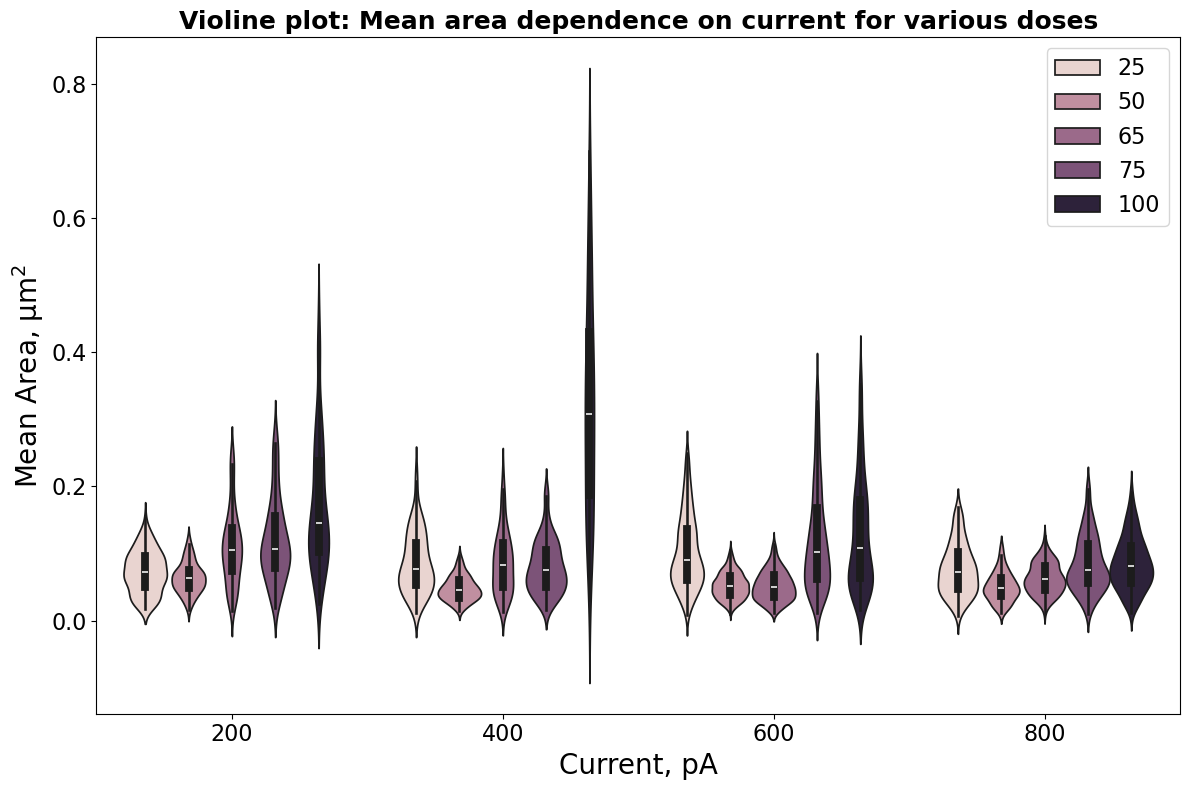

In [51]:
#* make violine olot of Area_nm for Currents for each doses
fig, ax = plt.subplots(figsize=(12, 8))
sns.violinplot(x='Current', 
            y='Area_nm',
            data=comb_dfArea_nm, 
            ax=ax,
            hue='Dose',
            # errorbar=('ci'),
            # capsize=0.2
            )
ax.set_title(f"Violine plot: Mean area dependence on current for various doses", fontsize=18, fontweight='bold')
ax.set_ylabel('Mean Area, $\\mathrm{µm}^2$', fontsize=20)
ax.set_xlabel('Current, pA', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=16, loc='upper right')
plt.tight_layout()
fig.savefig(save_path + f'violineplots_all_currents_for_each_doses.png', dpi=600)

plt.show()

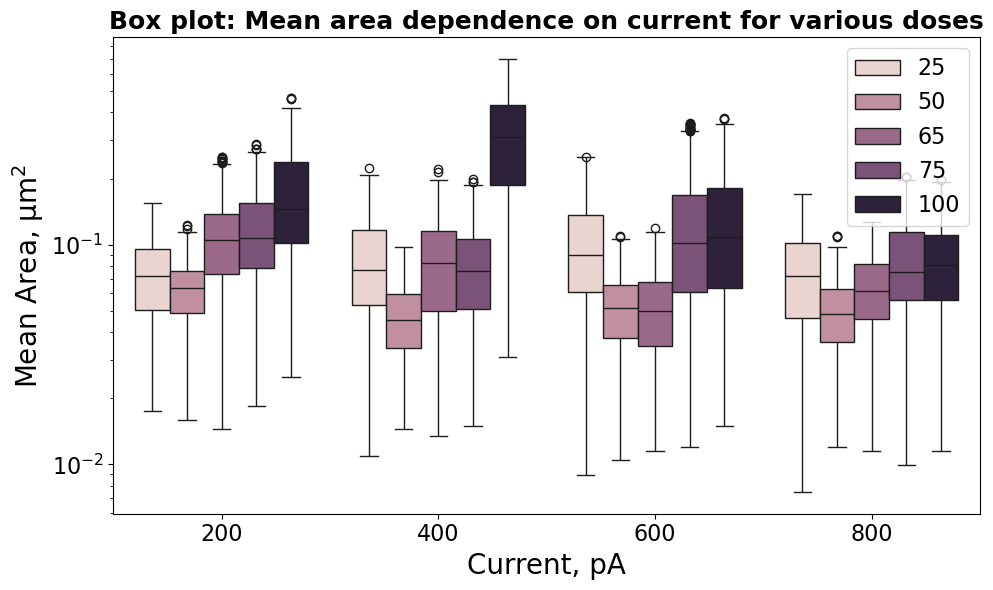

In [52]:
#* make bar olot of Area_nm for Currents summing over all doses
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='Current', 
            y='Area_nm',
            data=comb_dfArea_nm, 
            ax=ax,
            hue='Dose',
            )
ax.set_title(f"Box plot: Mean area dependence on current for various doses", fontsize=18, fontweight='bold')
ax.set_ylabel('Mean Area, $\\mathrm{µm}^2$', fontsize=20)
ax.set_xlabel('Current, pA', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=16, loc='upper right')
ax.set_yscale('log')
plt.tight_layout()
fig.savefig(save_path + f'boxplot_all_all_currents_for_each_dose.png', dpi=600)

plt.show()

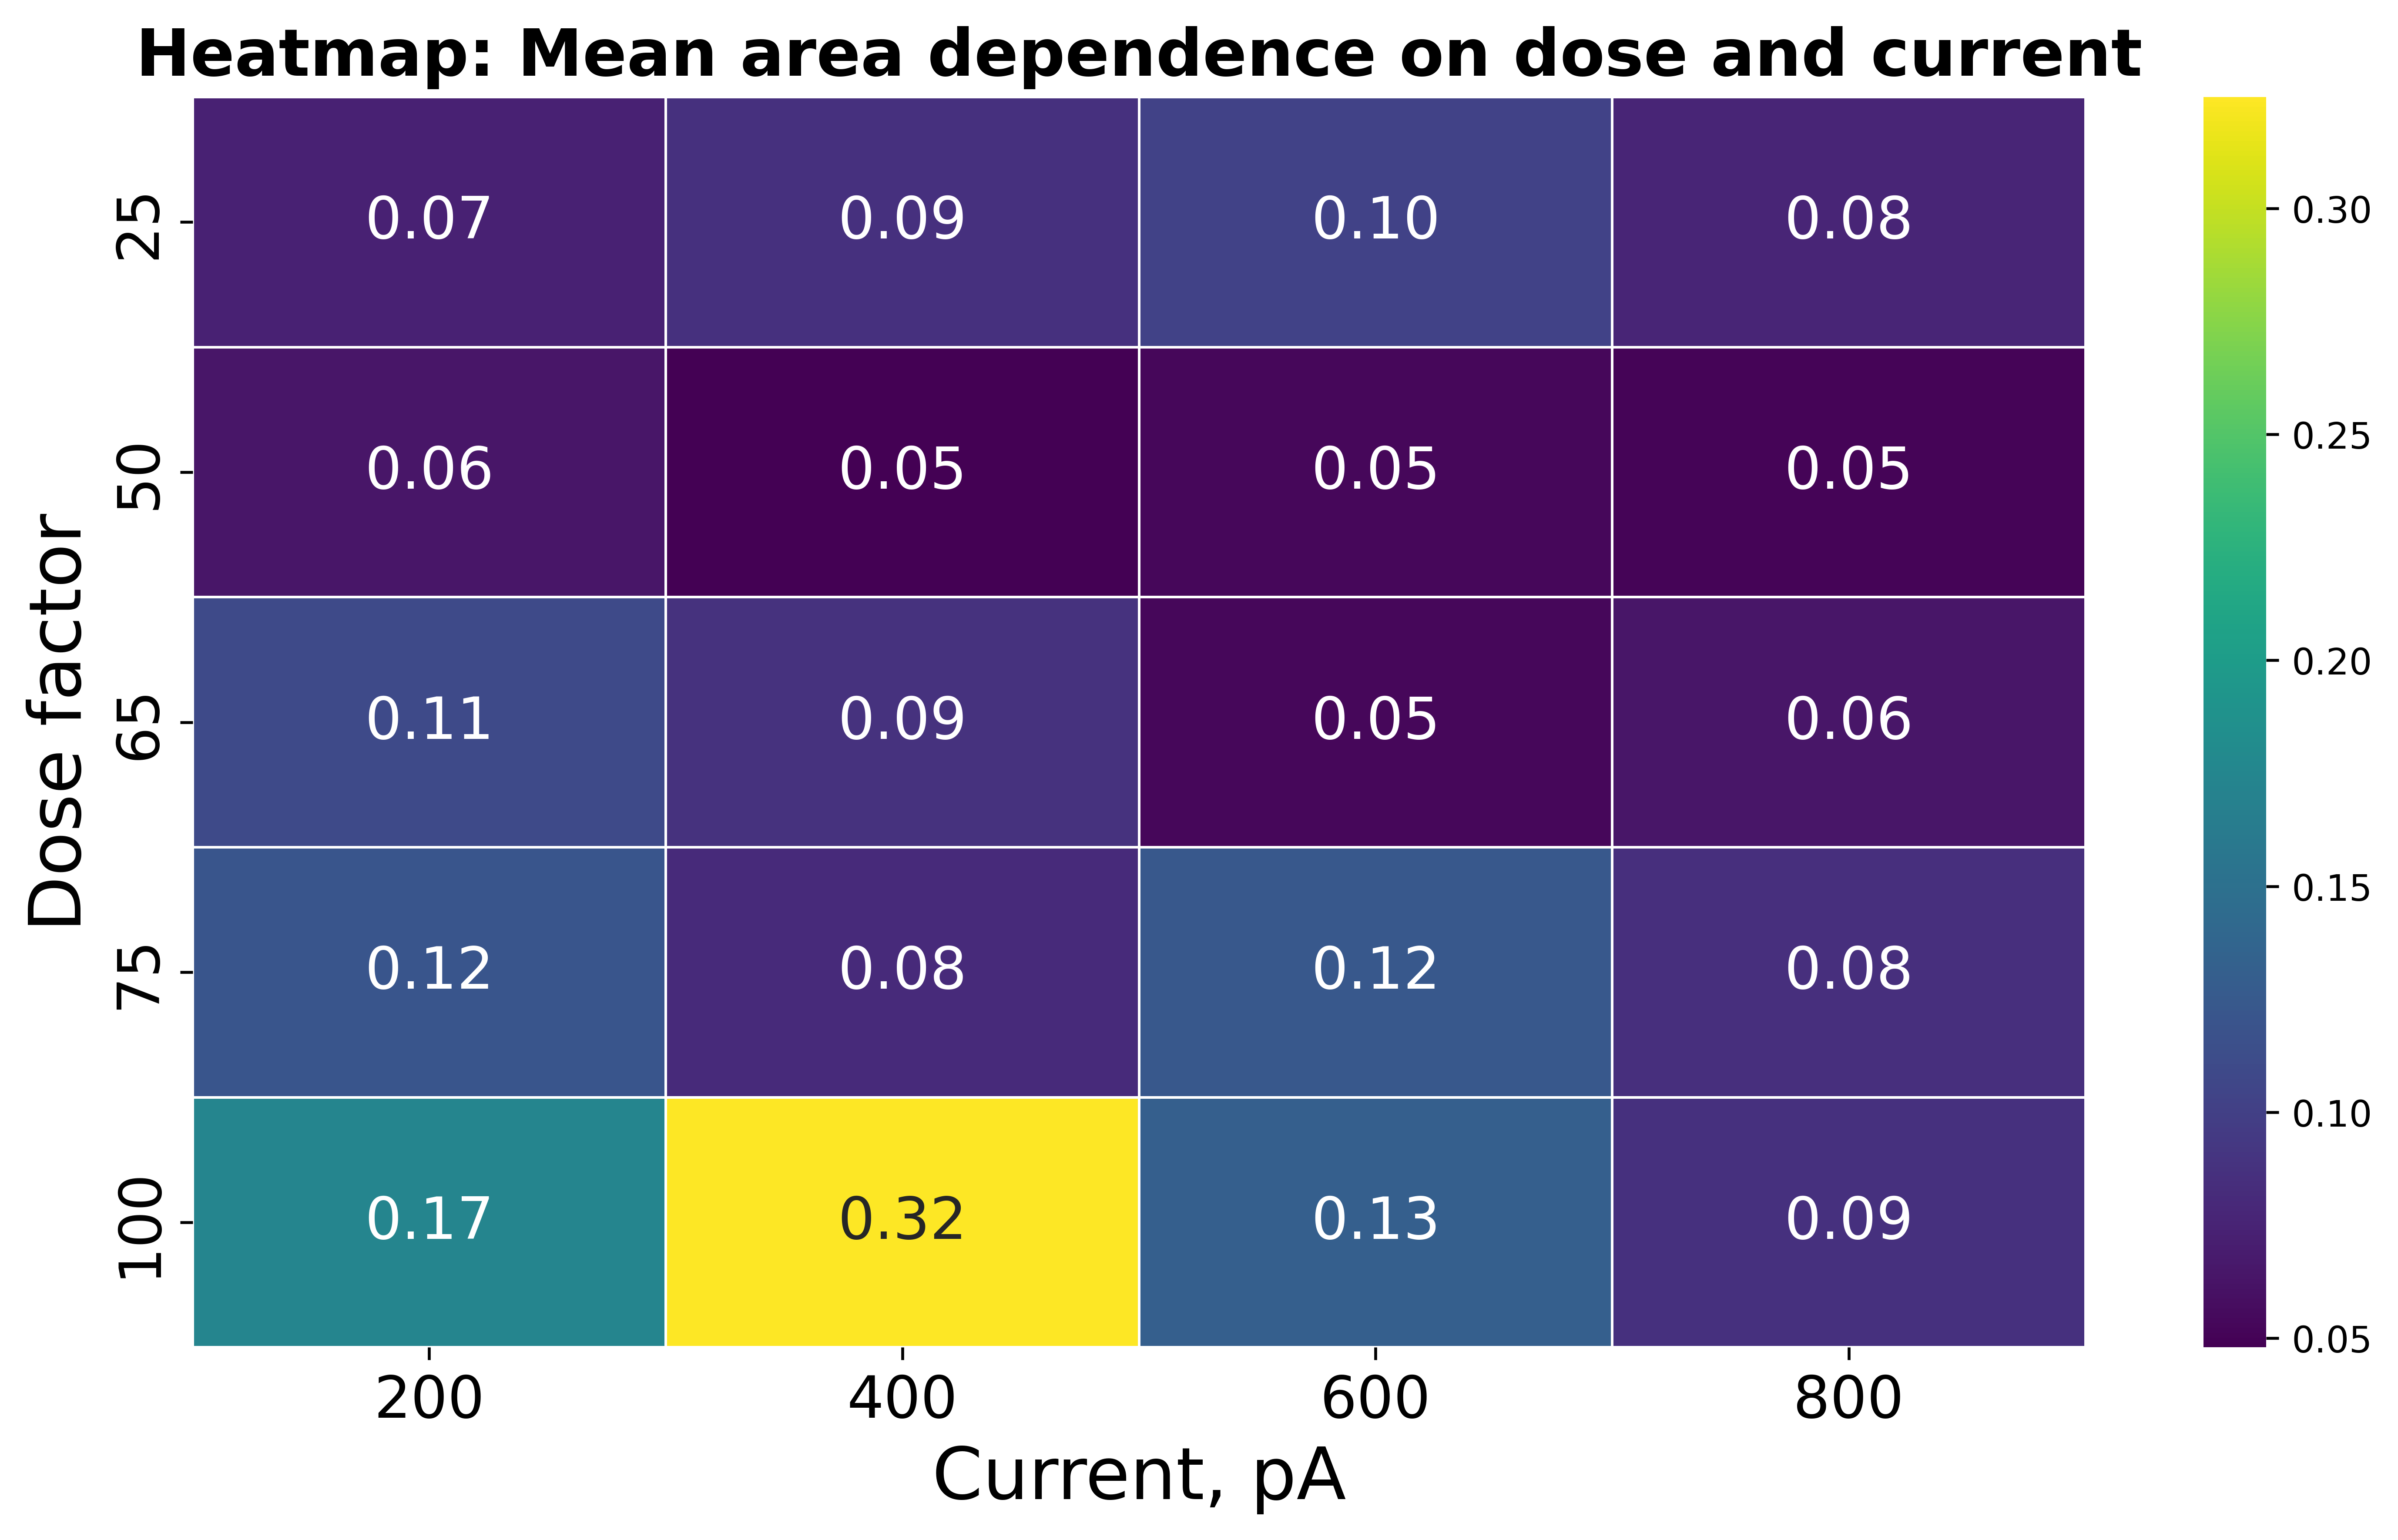

In [53]:
# heatmap
plt.figure(figsize=(10, 6), dpi=600)
sns.heatmap(comb_dfArea_nm.pivot_table(index='Dose', columns='Current', values='Area_nm'), cmap='viridis', annot=True, fmt=".2f", linewidths=0.5, annot_kws={"size": 16})
plt.title('Heatmap: Mean area dependence on dose and current', fontsize=18, fontweight='bold')
plt.ylabel('Dose factor', fontsize=20)
plt.xlabel('Current, pA', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()
plt.savefig(save_path + 'heatmap.png', dpi=600)
plt.show()


In [54]:
# perform regression analysis for the data
#* import necessary libraries
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

#* perform ANOVA analysis
# Create the model
model = ols('Area_nm ~ C(Dose) + C(Current)', data=comb_dfArea_nm).fit()

# Perform ANOVA
anova_results = anova_lm(model)
print(anova_results)

#* perform Tukey's HSD test
# Create the MultiComparison object
mc = MultiComparison(comb_dfArea_nm['Area_nm'], comb_dfArea_nm['Current'])

# Perform the Tukey's HSD test
result = mc.tukeyhsd()
print(result)



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                df     sum_sq   mean_sq           F        PR(>F)
C(Dose)        4.0   7.151931  1.787983  449.237335  0.000000e+00
C(Current)     3.0   1.316493  0.438831  110.257916  1.617678e-69
Residual    6086.0  24.222525  0.003980         NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   200    400   0.0071 0.1997 -0.0022  0.0163  False
   200    600  -0.0267    0.0 -0.0334   -0.02   True
   200    800   -0.038    0.0 -0.0463 -0.0297   True
   400    600  -0.0338    0.0 -0.0416  -0.026   True
   400    800  -0.0451    0.0 -0.0543 -0.0359   True
   600    800  -0.0113 0.0001 -0.0179 -0.0047   True
---------